In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

## Import and clean data

In [2]:
kawasaki_raw = pd.read_csv('kd_treatment_response.csv', na_values=[' '], 
                           parse_dates=['dob', 'Date_admission'])

In [27]:
kawasaki_raw.assign(responder=(kawasaki_raw.Responder==1)).groupby('Race2').responder.mean()

Race2
1    0.839465
2    0.862385
3    0.695652
Name: responder, dtype: float64

In [28]:
kawasaki_raw.head()

,Responder,StudyID,sex,dob,year_dob,month_dob,race,KD_complete,Race2,ethnicity,...,Ectasiaoraneurysm7,Ectasiaoraneurysm8,Ectasiaoraneurysm9,Ectasiaoraneurysm10,Ectasiaoraneurysm11,Totalectasia/aneurysm,age_months,age_years,age_norm,age_norm2
0,2,KD001,0,2004-12-06,2004,12,0,1,3,1,...,0,0,0,0,0,1,74.033333,6,0.958584,0.918883
1,2,KD002,1,2003-03-18,2003,3,8,2,3,0,...,0,0,0,0,0,1,19.200000,1,-0.730244,0.533256
2,2,KD003,1,2009-01-09,2009,1,4,0,1,1,...,1,1,1,0,0,8,11.800000,0,-0.958159,0.918068
3,2,KD004a,1,2003-05-08,2003,5,3,0,2,1,...,0,0,0,0,0,0,17.733333,1,-0.775416,0.601270
4,2,KD005,1,1997-09-10,1997,9,4,0,1,2,...,0,0,0,0,0,2,79.033333,6,1.112580,1.237834


Calculate age from admission year and birth year

In [4]:
kawasaki_raw['age_months'] = (kawasaki_raw.Date_admission - kawasaki_raw.dob).dt.days/30.
kawasaki_raw['age_months'].head()

0    74.033333
1    19.200000
2    11.800000
3    17.733333
4    79.033333
Name: age_months, dtype: float64

In [5]:
kawasaki_raw['age_years'] = (kawasaki_raw.age_months/12.).astype(int)

In [6]:
kawasaki_raw['age_norm'] = ((kawasaki_raw.age_months - kawasaki_raw.age_months.mean())
                            /kawasaki_raw.age_months.std())

In [7]:
kawasaki_raw['age_norm2'] = kawasaki_raw['age_norm']**2

In [8]:
relevant_cols = ['StudyID', 'Responder', 'sex', 'age_norm', 'age_norm2', 'age_years',
                 'Race2', 'ethnicity', 'KD_complete', 'Tier']

In [9]:
kawasaki_subset = (kawasaki_raw[relevant_cols]
                           .rename(columns={'sex':'male'})
                           .assign(responder=(kawasaki_raw.Responder==1).astype(int),
                                  black=(kawasaki_raw.Race2==2).astype(int),
                                  other=(kawasaki_raw.Race2==3).astype(int))
                           .drop(['Responder', 'Race2'], axis=1))
kawasaki_subset.head()

,StudyID,male,age_norm,age_norm2,age_years,ethnicity,KD_complete,Tier,black,other,responder
0,KD001,0,0.958584,0.918883,6,1,1,1,0,1,0
1,KD002,1,-0.730244,0.533256,1,0,2,1,0,1,0
2,KD003,1,-0.958159,0.918068,0,1,0,4,0,0,0
3,KD004a,1,-0.775416,0.601270,1,1,0,3,1,0,0
4,KD005,1,1.112580,1.237834,6,2,0,1,0,0,0


In [23]:
kawasaki_subset.groupby('black').responder.mean()

black
0    0.820290
1    0.862385
Name: responder, dtype: float64

Probability of responder does not seem to vary with age. Wide variation at the end is mostly a sample size artefact.

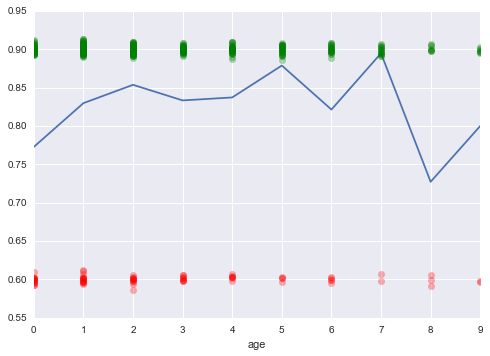

In [10]:
ax = (kawasaki_subset[kawasaki_subset.age_years<10]
              .assign(age_int=kawasaki_subset.age_years.astype(int))
              .groupby('age_int')).responder.mean().plot()
ax.set_xlabel('age')
responders = kawasaki_subset[kawasaki_subset.responder==1]
ax.plot(responders.age_years, np.random.normal(0.9, 0.005, size=len(responders)), 
        'go', alpha=0.3)

nonresponders = kawasaki_subset[kawasaki_subset.responder==0]
ax.plot(nonresponders.age_years, np.random.normal(0.6, 0.005, size=len(nonresponders)), 
        'ro', alpha=0.3)

In [11]:
kawasaki_subset.isnull().sum()

StudyID        0
male           0
age_norm       0
age_norm2      0
age_years      0
ethnicity      0
KD_complete    0
Tier           0
black          0
other          0
responder      0
dtype: int64

## Model specification

In [12]:
def interpolate(x0,y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d=dl+dr
    wl = dr/d

    return wl*y0[idx-1] + (1-wl)*y0[idx]


In [13]:
import theano.tensor as tt
GaussianRandomWalk = pm.distributions.timeseries.GaussianRandomWalk

covs = ['male', 'black', 'other']
k = len(covs)
nknots = 7

knots = np.linspace(kawasaki_subset.age_norm.min(), kawasaki_subset.age_norm.max(), nknots)

with pm.Model() as model:
    
    # Baseline probability of response
    θ = pm.Normal('θ', 0, sd=10)
    # Coefficients for covariates
    β = pm.Normal('β', 0, sd=10, shape=k)
    
    odds = pm.Deterministic('odds', tt.exp(β))
    
    # Age effect (non-linear)
    σ = pm.HalfCauchy('σ', 2.5)
    y = GaussianRandomWalk('y', sd=σ, shape=nknots)

    α = pm.Deterministic('α', interpolate(knots, y, kawasaki_subset.age_norm))
    
    
    # Probabilities
    p_race_female = pm.Deterministic('p_race_female', pm.invlogit(θ))
    p_race_male = pm.Deterministic('p_race_male', pm.invlogit(θ + β[1]))
    p_race_black_female = pm.Deterministic('p_race_black_female', 
                                           pm.invlogit(θ + β[1]))
    p_race_black_male = pm.Deterministic('p_race_black_male', 
                                         pm.invlogit(θ + β[0] + β[1]))
        
    π = pm.invlogit(θ + tt.dot(kawasaki_subset[covs].values, β)+ α*kawasaki_subset.age_norm.values)
    
    responder = pm.Bernoulli('responder', π, observed=kawasaki_subset.responder)
    

INFO (theano.gof.compilelock): Waiting for existing lock by process '48770' (I am process '50575')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/fonnescj/.theano/compiledir_Darwin-15.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir


Applied log-transform to σ and added transformed σ_log_ to model.


In [14]:
with model:
    
    advi_fit = pm.variational.advi(n=100000)

Iteration 0 [0%]: ELBO = -277.97
Iteration 10000 [10%]: Average ELBO = -267.98
Iteration 20000 [20%]: Average ELBO = -224.99
Iteration 30000 [30%]: Average ELBO = -222.47
Iteration 40000 [40%]: Average ELBO = -222.0
Iteration 50000 [50%]: Average ELBO = -221.95
Iteration 60000 [60%]: Average ELBO = -221.89
Iteration 70000 [70%]: Average ELBO = -221.98
Iteration 80000 [80%]: Average ELBO = -221.93
Iteration 90000 [90%]: Average ELBO = -221.92
Finished [100%]: Average ELBO = -221.91


In [17]:
iterations = 2000
burn = 1000

In [19]:
with model:
    
    trace = pm.sample(iterations, start=advi_fit[0], njobs=2)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to σ_log_
Assigned NUTS to y
 [-----------------100%-----------------] 2000 of 2000 complete in 57.7 sec

Odds ratios for responder. Tabulated values below plot.

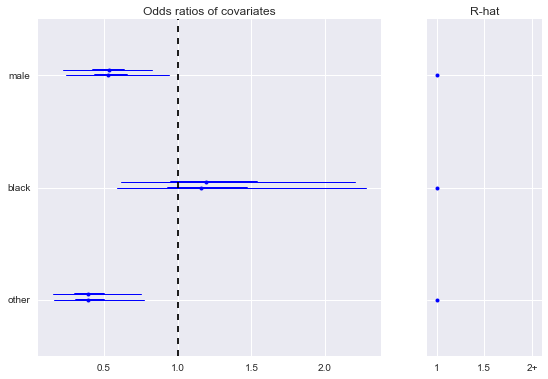

In [20]:
pm.forestplot(trace[burn:], varnames=['odds'], ylabels=covs, vline=1, 
              main='Odds ratios of covariates')

Age effect

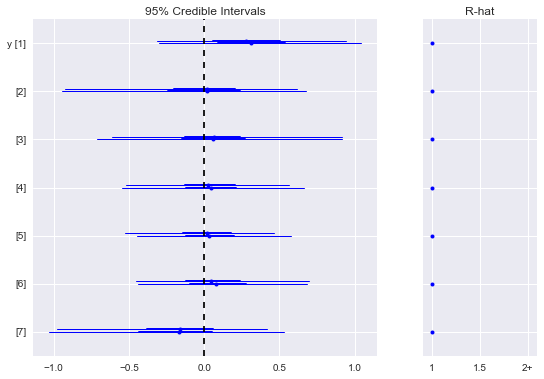

In [21]:
pm.forestplot(trace[burn:], varnames=['y'])

In [22]:
pm.summary(trace[burn:], varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.552            0.175            0.009            [0.246, 0.898]
  1.260            0.441            0.015            [0.569, 2.203]
  0.422            0.168            0.006            [0.168, 0.780]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.277          0.432          0.528          0.648          0.967
  0.634          0.945          1.179          1.498          2.370
  0.192          0.307          0.393          0.498          0.857

